# Introduction to NORDic

This vignette focuses on the pipeline for the identification of networks (**NORDic NI**) and the one for the prioritization of targets (**NORDic PMR**). For more detailed introductions, please check out the [notebooks](https://github.com/clreda/NORDic/tree/main/notebooks) on the [GitHub page](https://github.com/clreda/NORDic). 

For illustration purposes, this vignette focuses on building a *very* small regulatory model of the Congenital Central Hypoventilation Syndrome (CCHS), also called "Ondine syndrome", from scratch using **NORDic NI**, and using this model to prioritize genes according to their regulatory influence (**NORDic PMR**).

## Import

In [1]:
import NORDic

## The Congenital Central Hypoventilation Syndrome (CCHS)

Congenital central hypoventilation syndrome (MedGen Concept ID "C1275808") is a disorder that affects normal breathing. People with this disorder take shallow breaths (hypoventilate), especially during sleep, resulting in a shortage of oxygen and a buildup of carbon dioxide in the blood. 

Ordinarily, the part of the nervous system that controls involuntary body processes (autonomic nervous system) would react to such an imbalance by stimulating the individual to breathe more deeply or wake up. This nervous system reaction is impaired in people with CCHS.  [(source)](https://medlineplus.gov/genetics/condition/congenital-central-hypoventilation-syndrome/)

Most of the CCHS cases can be linked to a mutation in the PHOX2B gene, and a large percentage of cases are related to an alanine expansion which length might be correlated with the severity of the symptoms.

## I. Building a small regulatory model of CCHS (**NORDic NI**)

Given only the paragraphs above (disease name, most likely affected cell lines), we are going to build in an automated way a regulatory model of CCHS.

### I.a. Registration to databases used by **NORDic NI**

In the absence of data normally used for network inference (a prior knowledge network, a set of experiments, a set of genes of interest, ...), **NORDic** retrieves data from public databases. The registration to these databases is free (often only requires an academic e-mail address), time-unlimited, but mandatory.

#### I.a.1. Registration to the DisGeNET database

Click on [this link](https://www.disgenet.org/signup/) to sign up to DisGeNET. Once you are registered, open an empty .TXT file, and write down
- on the first line: the e-mail address used for registration
- on the second line: the chosen password
Save the file, and replace the relative path to that file in the cell below

In [2]:
DisGeNET_credentials = "../tests/credentials_DISGENET.txt"

#### I.a.2. Registration to the STRING database

The STRING database requires an identification of the person sending requests to the database. Write down on the first line of an empty .TXT file your e-mail address, and replace the relative path to that file in the cell below:

In [3]:
STRING_credentials = "../tests/credentials_STRING.txt"

#### I.a.3 Registration to the LINCS L1000 database access CLUE.io

Click on [this link](https://clue.io/lincs) to sign up to CLUE.io. Once you are registered, open an empty .TXT file, and write down
- on the first line: the e-mail address used for registration
- on the second line: the chosen password
- on the third line: the user key you were assigned
Save the file, and replace the relative path to that file in the cell below

In [4]:
LINCS_credentials = "../tests/credentials_LINCS.txt"

### I.b Selection of parameters in **NORDic NI**

The goal of **NORDic** is to allow to infer a network in the most transparent and reproducible fashion possible. As such, it relies on a (rather large) set of parameters which control the pipeline and the processing of biological data. For the actual definition of the parameters and an overview of the pipeline, please have a look at the following [reference](https://clreda.github.io/assets/reda2022prioritization_accepted.pdf):


> Réda, C., & Delahaye-Duriez, A. (2022). Prioritization of Candidate Genes Through Boolean Networks. In *International Conference on Computational Methods in Systems Biology* (pp. 89-121). Springer, Cham.

First, define the seed number (for an increased reproducibility), along with the number of threads to allocate to the network inference process

In [5]:
seed_number=123456
from multiprocessing import cpu_count
njobs=max(1,cpu_count()-2) ## all available threads but 2

Second, define the folder to create (relative to the folder in which the present notebook is located), in which to store intermediary files and the network itself

In [6]:
file_folder="MODELS/Ondine/"

As previously mentioned, the only information provided to **NORDic** is *only* the name of the disease itself (that is, its Concept ID on [NCBI MedGen](https://www.ncbi.nlm.nih.gov/medgen/)), the species (the taxonomy ID on [NCBI Taxonomy](https://www.ncbi.nlm.nih.gov/Taxonomy/TaxIdentifier/tax_identifier.cgi)), and the cell lines (most relevant [immortalized cell lines](https://lincsportal.ccs.miami.edu/cells/#/) in **LINCS L1000**). If we were interested in several subtypes of diseases, one could write down a list of Concept IDs.

In [7]:
taxon_id=9606 # human species
disease_cids=["C1275808"] ## Concept ID of CCHS

Optionally, in order to guide the inference of the regulatory mechanisms at play, one can define the cell types of interest (which should be present in the database [LINCS L1000](https://lincsproject.org/)). Otherwise, all cell lines in LINCS L1000 are considered.

In [8]:
cell_lines=["NPC", "SHSY5Y"] # brain cell lines in LINCS L1000

#### 1.b.1 Information about the disease

In the absence of a set of genes of interest to focus on, **NORDic** retrieves a set of disease-associated genes from the DisGeNET database

In [9]:
DISGENET_args = {"credentials": DisGeNET_credentials, "disease_cids": disease_cids}

#### 1.b.2 Selection of parameters relative to the prior knowledge network 

A prior knowledge network is built using protein-protein interaction networks (PPI) from the STRING database. One can set a threshold on the "combined score" provided by STRING on every edge of the PPI

In [10]:
STRING_args = {"credentials": STRING_credentials,
               "score": 0, # threshold on the minimum score of STRING edges
}

During inference, the edges retrieved from the STRING database might be filtered out (*filter=True*) based on the associated gene expression pairwise correlation (correlation>*tau*), preserving the connectivity of the network (i.e., having a single weakly connected component, that is, no isolated bits) (*connected=True*).

In [11]:
EDGE_args = {
        "tau": 0, # filter edges according to the genepairwise expression correlation
        "filter": True, # whether to apply the filter
        "connected": True, # whether to preserve the connectivity of the network
}

Since version 2.2.0, one can preserve nodes which are not measured by LINCS L1000 or which do not match an EntrezGene ID (which allows considering miRNA nodes, for instance). In order to do so, set the following parameter to True (to preserve the initial behavior, which is the default one, set it to False):

In [12]:
accept_nonRNA=True

Since version 2.2.3, **NORDic** may infer the sign of the edges in an *existing* prior knowledge network using the gene expression data retrieved from **LINCS L1000**, instead of using the sign of the edge-related scores in the network stored at "network_fname", by setting option *preserve_network_sign* to **False**. The default behavior is *preserve_network_sign=* **True**, and is consistent with the behavior of past versions of **NORDic**.

In [13]:
preserve_network_sign=False

Since version 2.3.0, the user can directly retrieve gene annotations and the network topology from the meta-database [OmniPath](https://omnipathdb.org/) using **NORDic** with function *get_network_from_OmniPath*. However, the filtering of the resulting network has to be done by the user (potentially based on the returned gene annotations). Functions which might help the trimming are present in file *src/UTILS/utils_network.py*. The resulting network may then be fed to **NORDic NI** by setting parameter *network_fname* below to the path to the resulting network from OmniPath.

In [14]:
from NORDic.UTILS.utils_network import get_network_from_OmniPath
help(get_network_from_OmniPath)

Help on function get_network_from_OmniPath in module NORDic.UTILS.utils_network:

get_network_from_OmniPath(gene_list=None, disease_name=None, species='human', sources_int=None, domains_int=None, types_int=None, min_curation_effort=-1, domains_annot='HPA_tissue', quiet=False)
    Retrieve a network from OmniPath
    @param  gene_list       Python character string[default=None]: List of genes to consider (or do not filter the interactions from Omnipath if =None)
    @param  disease_name    Python character string[default=None]: Disease name (in letters) to consider
    @param  species Python character string[default=None]: Species to consider (either "human", "mouse", or "rat")
    @param  sources_int     Python character string[default=None]: Which databases for interactions to consider (if =None, consider them all)
    @param  domains_int     Python character string[default=None]:
    @param  types_int       Python character string[default=None]: Types of interactions, e.g., "post_tra

#### 1.b.3 Selection of parameters relative to experimental constraints

In the absence of a set of experimental profiles, **NORDic** retrieves a set of experimental profiles from the database LINCS L1000. Note that it downloads files from LINCS L1000 (which might be large, around 73GB in total). One might also set a nonnegative threshold on the quality of experiments retrieved from LINCS L1000 (*thres_iscale*), which was introduced by

> Cheng, Lijun, and Lang Li. "Systematic quality control analysis of LINCS data." CPT: pharmacometrics & systems pharmacology 5.11 (2016): 588-598.

The threshold recommended by that paper is 0. However, if you would like not to filter any experiment out, set this value to **None**.

In [15]:
LINCS_args = {
        "path_to_lincs": "../lincs/", # where to store locally LINCS L1000 files
        "credentials": LINCS_credentials, "cell_lines": cell_lines,
        "thres_iscale": None, # threshold to filter out experiments from LINCS L1000
}

Since **NORDic** infers a Boolean network, the experimental profiles retrieved from LINCS L1000 need to be binarized; i.e., all expression values are either 0 (inactive), 1 (active), or NaN (undetermined status: neither fully inactive nor active). The control upon this binarization is made through parameter *bin_thres*, which is comprised between 0 (all genes have an undetermined status, that is, no constraint from the experiments will be enforced) and 0.5 (all genes have a binary status, which correspond to strong experimental constraints).

In [16]:
SIG_args = {
    "bin_thres": 0.5, # threshold to binarize gene expression values
}

Since version 2.2.0, **NORDic** can try and infer a network -without returning an error- even when no experimental data is available. In that case, there are no experimental constraints, and it boils down to choosing appropriate parameters in Section **1.b.2** to filter out (or not) edges. In order to do so, set the following parameter to **False** (to preserve the initial behavior, which is the default one, set it to **True**):

In [17]:
force_experiments=False

#### 1.b.4 Selection of parameters relative to the inference of networks

Once **NORDic** has built the prior knowledge network, and the Boolean experimental constraints, it uses BoneSIS to infer valid solution networks. Please refer to the following paper:

> Chevalier, Stéphanie, et al. "Synthesis of boolean networks from biological dynamical constraints using answer-set programming." 2019 IEEE 31st International Conference on Tools with Artificial Intelligence (ICTAI). IEEE, 2019.

In [18]:
BONESIS_args = {
        "limit": 1, # maximum number of solution networks to infer
        "exact": True, # should any solution use ALL edges from the prior knowledge network?
        "max_maxclause": 3, # quantifies the complexity of the regulatory functions
}

#### 1.b.5 Advanced parameters

Those parameters guide the selection of a final network among all valid solutions. However, they can be ignored, as the default values usually do the trick. Please refer to the paper for more information.

In [19]:
DESIRABILITY = {"DS": 3, "CL": 3, "Centr": 3, "GT": 1} # how to select an optimal model

### I.c Summary of parameters in **NORDic NI**

Let us sum up the parameter values:

In [20]:
## Registration to databases
DisGeNET_credentials = "../tests/credentials_DISGENET.txt"
STRING_credentials = "../tests/credentials_STRING.txt"
LINCS_credentials = "../tests/credentials_LINCS.txt"

## Parameters
seed_number=123456
from multiprocessing import cpu_count
njobs=max(1,cpu_count()-2) ## all available threads but 2
file_folder="ToyOndine/"
taxon_id=9606 # human species
disease_cids=["C1275808"] ## Concept ID of Ondine syndrome
cell_lines=["NPC", "SHSY5Y"] # brain cell lines in LINCS L1000

## Information about the disease
DISGENET_args = {"credentials": DisGeNET_credentials, "disease_cids": disease_cids}

## Selection of parameters relative to the prior knowledge network 
STRING_args = {"credentials": STRING_credentials, "score": 0}
EDGE_args = {"tau": 0, "filter": True, "connected": True}
accept_nonRNA=True
preserve_network_sign=True

## Selection of parameters relative to experimental constraints
LINCS_args = {"path_to_lincs": "../lincs/", "credentials": LINCS_credentials, "cell_lines": cell_lines, 
              "thres_iscale": None}
SIG_args = {"bin_thres": 0.5}
force_experiments=False

## Selection of parameters relative to the inference of networks
BONESIS_args = {"limit": 1, "exact": True, "max_maxclause": 3}

## Advanced
DESIRABILITY = {"DS": 3, "CL": 3, "Centr": 3, "GT": 1}

Don't be afraid! There is a rule of thumb to decide which parameter values to choose:
- First choose score=0 in the STRING arguments, thres_iscale=None in the LINCS arguments, tau=0 to select all possible edges in the edge-wise arguments, and bin_thres=0.5 to restrict as much as possible experiment-wise in the signature-wise arguments, max_maxclause=3 to consider more simple regulatory functions, and exact=False in the BoneSiS arguments
- If there is an explosion in RAM use (happens for a good personal computer when the number of edges fed to the Boolean network is >3,000), reduce the number of edges by playing with parameters score and tau
- If no model is found, decrease the value of parameter bin_thres in [0,0.5], or increase max_maxclause (leave it smaller than 10, otherwise the RAM goes KABOOM)
- If there are too many models, add more constraints by increasing the value of score, tau, or bin_thres, or setting exact=True (meaning that any solution should use ALL edges fed to the solver)

Moreover, as a general rule: if you prefer having a denser network at the end of the inference, decrease the value of bin_thres. On the contrary, if you prefer putting more credence on experimental contraints, bin_thres should be increased.

Note that, as previously mentioned, one can feed a prior knowledge network (through *network_fname*: see [this notebook](https://github.com/clreda/NORDic/blob/main/notebooks/NORDic%20Network%20Identification%20(NI)%20Part%20II.ipynb)), a pre-selected list of genes (through *path_to_genes*: see [this notebook](https://github.com/clreda/NORDic/blob/main/notebooks/NORDic%20Network%20Identification%20(NI)%20Part%20III.ipynb)), and/or a list of gene perturbation experiments (through *experiments_fname*: see [this notebook](https://github.com/clreda/NORDic/blob/main/notebooks/NORDic%20Network%20Identification%20(NI)%20Part%20IV.ipynb)). By default, all those parameters are set to **None**, and **NORDic** infers the corresponding elements from databases and computational methods.

In order to speed up the computation here, we actually give to **NORDic** the network from STRING based on genes associated with CCHS in DisGeNet, and the experiment retrieved from LINCS L1000:

In [21]:
import pandas as pd
## The undirected, unsigned network from STRING
network_content = pd.DataFrame([], index=["preferredName_A", "preferredName_B", "sign", "directed", "score"])
network_content[0] = ["PHOX2B", "BDNF", 2, 0, 0.342]
network_content[1] = ["PHOX2B", "GDNF", 2, 0, 0.572]
network_content[2] = ["PHOX2B", "RET", 2, 0, 0.605]
network_content[3] = ["PHOX2B", "EDN3", 2, 0, 0.607]
network_content[4] = ["PHOX2B", "ASCL1", 2, 0, 0.676]
network_content[5] = ["ASCL1", "RET", 2, 0, 0.397]
network_content[6] = ["ASCL1", "EDN3", 2, 0, 0.433]
network_content[7] = ["ASCL1", "GDNF", 2, 0, 0.47]
network_content[8] = ["ASCL1", "BDNF", 2, 0, 0.519]
network_content[9] = ["EDN3", "BDNF", 2, 0, 0.15]
network_content[10] = ["EDN3", "RET", 2, 0, 0.622]
network_content[11] = ["EDN3", "GDNF", 2, 0, 0.634]
network_content[12] = ["RET", "BDNF", 2, 0, 0.438]
network_content[12] = ["RET", "GDNF", 2, 0, 0.999]
network_content[12] = ["GDNF", "BDNF", 2, 0, 0.95]
network_content.T.to_csv("network.tsv", sep="\t", index=None)
network_content

,0,1,2,3,4,5,6,7,8,9,10,11,12
preferredName_A,PHOX2B,PHOX2B,PHOX2B,PHOX2B,PHOX2B,ASCL1,ASCL1,ASCL1,ASCL1,EDN3,EDN3,EDN3,GDNF
preferredName_B,BDNF,GDNF,RET,EDN3,ASCL1,RET,EDN3,GDNF,BDNF,BDNF,RET,GDNF,BDNF
sign,2,2,2,2,2,2,2,2,2,2,2,2,2
directed,0,0,0,0,0,0,0,0,0,0,0,0,0
score,0.342,0.572,0.605,0.607,0.676,0.397,0.433,0.47,0.519,0.15,0.622,0.634,0.95


In [22]:
import pandas as pd
## An experiment retrieved from LINCS L1000 involving those genes
index=["PHOX2B","EDN3","RET","GDNF","BDNF","ASCL1","cell_line","annotation","perturbed","perturbation","sigid"]
experiments_content = pd.DataFrame([], index=index)
experiments_content["BDNF_KD_SHSY5Y"] = [1,1,1,0,0,0,"Cell","2","BDNF","KD","Sig1"] ## mutated profile
experiments_content["initial_SHSY5Y"] = [1,1,1,1,0,0,"Cell","1","None","None","Sig2"] ## control/initial profile
experiments_content.to_csv("experiments.csv")
experiments_content.T

,PHOX2B,EDN3,RET,GDNF,BDNF,ASCL1,cell_line,annotation,perturbed,perturbation,sigid
BDNF_KD_SHSY5Y,1,1,1,0,0,0,Cell,2,BDNF,KD,Sig1
initial_SHSY5Y,1,1,1,1,0,0,Cell,1,None,None,Sig2


### 1.d. Network inference

A single function takes these parameters, and returns a single solution network. Note that this step can be quite time-consuming depending on the number of genes and the size of the prior knowledge network (sometimes in (dozens of) hours...). However, in this instance, it should be quick.

In [23]:
from NORDic.NORDic_NI.functions import network_identification
solution = network_identification(file_folder, taxon_id, path_to_genes=None, 
    network_fname="network.tsv", experiments_fname="experiments.csv", 
    disgenet_args=DISGENET_args, string_args=STRING_args, edge_args=EDGE_args, lincs_args=LINCS_args, 
    sig_args=SIG_args, bonesis_args=BONESIS_args, weights=DESIRABILITY, seed=seed_number, njobs=njobs,
    force_experiments=force_experiments, accept_nonRNA=accept_nonRNA, preserve_network_sign=preserve_network_sign)

--- DATA IMPORT ---
1. Import gene set from DisGeNET... ... 6 genes imported.
2. Import network from network.tsv... ... 13 edges in model (including 0 directed edges) with a total of 6 non-isolated genes
3. Import experiments from experiments.csv... 
	2 cell lines are considered (['NPC', 'SHSY5Y'])
... 6 genes in 0 profiles (0 experiments)

--- CONSTRAINT BUILDING ---
1. Filtering out edges by minimum set of edges with highest score which preserve connectivity... ... 13 unique edges involving genes both in experiments (6 genes in total)
... score_STRING 0.000000	6 genes (non isolated in PPI)	52 edges in PPI
2. Build topological constraints from filtered edges using gene expression data...  ...... 0 negative, 26 positive undirected interactions (26 edges in total), 6 non isolated genes in experiments
3. Build dynamical constraints by binarization of experimental profiles...  ...... no experiments.

--- INFER BOOLEAN NETWORK ---
1. Generate solutions from topological & dynamical constrai

  0%|                                                                    | 0/1 [00:00<?, ?it/s]

Grounding...done in 0.0s
Found 1 solutions in 0.0s (first in 0.0s; rate 0.0s)

100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.19it/s]

--- SELECTION OF OPTIMAL MODEL ---
A. Select an optimal model based on a topological criteria...  ...1 solutions (1 unique solutions)
... 1 solutions (0/7 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 26 edges


<MODEL VISUALIZATION> Maximal solution: 26 edges
           1
GTP  0.87416
<MODEL SELECTION> Saving optimal model in 'ToyOndine//solution.bnet' ...
ASCL1, BDNF|RET|(EDN3&GDNF&PHOX2B)
BDNF, PHOX2B|(ASCL1&EDN3&GDNF)
EDN3, ASCL1&BDNF&GDNF&PHOX2B&RET
GDNF, PHOX2B|(ASCL1&EDN3)|(BDNF&EDN3)
PHOX2B, RET|(ASCL1&BDNF&EDN3&GDNF)
...
... saved!


### 1.e. Network visualization

If you have a look at the folder *file_folder* (here, "ToyOndine/"), you can notice that there are a lot of intermediary files, comprising an image of the inferred network *inferred_max_criterion_solution*

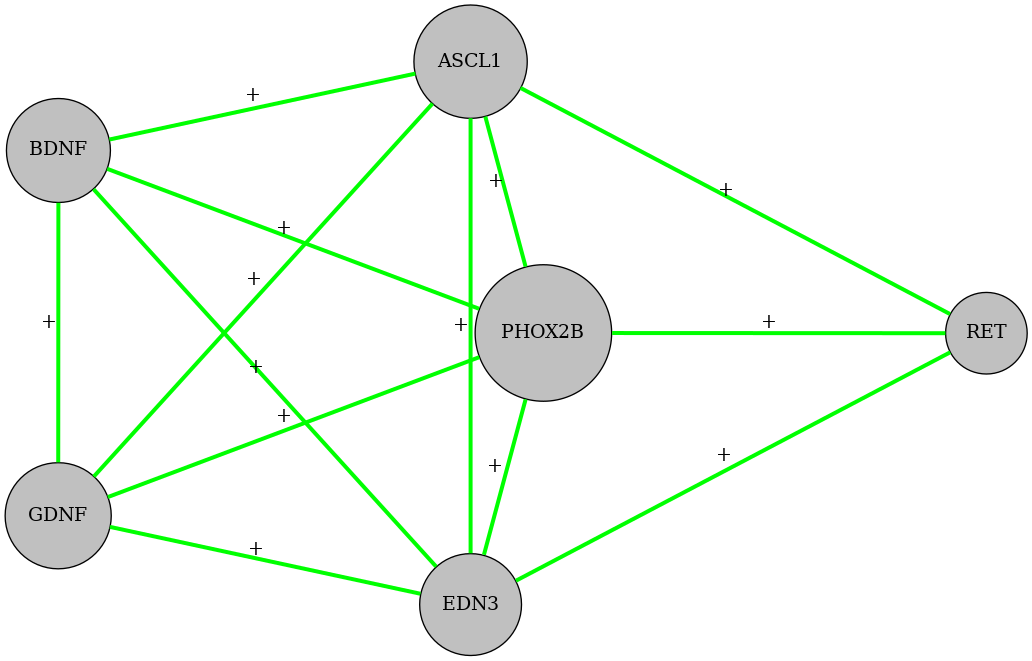

In [24]:
from IPython.display import Image
Image(filename=file_folder+'inferred_max_criterion_solution.png') 

and the .BNET file *solution.bnet* that contains the gene regulatory functions defining the dynamics of the Boolean network 

In [25]:
with open(file_folder+"solution.bnet", "r") as f:
    network = f.read()
print(network)

ASCL1, BDNF|RET|(EDN3&GDNF&PHOX2B)
BDNF, PHOX2B|(ASCL1&EDN3&GDNF)
EDN3, ASCL1&BDNF&GDNF&PHOX2B&RET
GDNF, PHOX2B|(ASCL1&EDN3)|(BDNF&EDN3)
PHOX2B, RET|(ASCL1&BDNF&EDN3&GDNF)
RET, (ASCL1&EDN3)|(ASCL1&PHOX2B)


If needed, you can convert this network into network (at *file_folder*/solution_cytoscape.sif) and style (at *file_folder*/solution_cytoscape.xml) files readable by [Cytoscape](https://cytoscape.org/)

In [26]:
from NORDic.NORDic_NI.functions import solution2cytoscape
from NORDic.UTILS.utils_grn import load_grn
solution = load_grn(file_folder+"solution.bnet")
solution2cytoscape(solution, file_folder+"solution_cytoscape")

## II. Prioritization of master regulators (**NORDic PMR**)

**NORDic PMR** exploits a Boolean network in order to find master regulators. Its approach is based on influence maximization. For more information about the method, please have a look at the following [reference](https://clreda.github.io/assets/reda2022prioritization_accepted.pdf):

> Réda, C., & Delahaye-Duriez, A. (2022). Prioritization of Candidate Genes Through Boolean Networks. In *International Conference on Computational Methods in Systems Biology* (pp. 89-121). Springer, Cham.

The input network does not need to be an output of **NORDic NI** (although it is compatible), and, as such, the corresponding .BNET file can be independenty generated. We however need "patient" profiles for CCHS in order to give the transcriptional context of perturbations in the network. In our case, we will actually generate those at random, since this notebook is for illustration purposes.

In [27]:
import numpy as np
np.random.seed(12345)
with open(file_folder+"solution.bnet", "r") as f:
    genes = [line.split(", ")[0] for line in f.read().split("\n") if (len(line)>0)]
state_len = 10 # number of patient states to generate
states = pd.DataFrame(
  [np.random.choice([0,1], p=[0.5,0.5], size=len(genes)).tolist() for _ in range(state_len)]
  , columns=genes, index=["Patient %d" % (i+1) for i in range(state_len)]).T
states

,Patient 1,Patient 2,Patient 3,Patient 4,Patient 5,Patient 6,Patient 7,Patient 8,Patient 9,Patient 10
ASCL1,1,1,0,1,0,0,1,1,1,1
BDNF,0,1,0,1,1,1,0,0,0,0
EDN3,0,1,0,1,1,1,1,0,1,0
GDNF,0,1,1,1,1,0,1,0,0,0
PHOX2B,1,1,1,0,1,0,1,0,1,1
RET,1,1,1,0,0,1,1,0,1,1


### II.a. Selection of parameters in **NORDic PMR**

Again, we need to set the random seed for increased reproducibility, and set the maximum number of threads to use

In [28]:
seed_number=12345
from multiprocessing import cpu_count
njobs=min(5,max(1,cpu_count()-2)) #minimum between all available -2 and 5

As the goal is to rank genes by their *individual* regulatory influence in the network, we will consider genewise mutations

In [29]:
k=1

To get more information about parameters, please refer to [this notebook](https://github.com/clreda/NORDic/blob/main/notebooks/NORDic%20Prioritization%20of%20Master%20Regulators%20(PMR).ipynb)

In [30]:
IM_params = {
    "seed": seed_number, "gene_inputs": genes, # genes to be perturbed
    "gene_outputs": genes # genes to be observed: it is advised to avoid genes without regulators in that list
}

SIMU_params = {
    'nb_sims': 1000, 'rates': "fully_asynchronous", 'thread_count': njobs, 'depth': "constant_unitary",
}

All in all

In [31]:
seed_number=12345
from multiprocessing import cpu_count
njobs=min(5,max(1,cpu_count()-2))

k=1

IM_params = {"seed": seed_number, "gene_inputs": genes, "gene_outputs": genes}

SIMU_params = {'nb_sims': 1000, 'rates': "fully_asynchronous", 'thread_count': njobs, 'depth': "constant_unitary"}

### II.b. Gene ranking

In [32]:
from NORDic.NORDic_PMR.functions import greedy

S, spreads = greedy(file_folder+"solution.bnet", k, states, IM_params, SIMU_params, save_folder=file_folder)

<NORD_PMR> Iteration k=1
	<NORD_PMR> Initial state Patient 1 (gene(s):ASCL1)
	<NORD_PMR> Initial state Patient 5 (gene(s):ASCL1)
	<NORD_PMR> Initial state Patient 2 (gene(s):ASCL1)
	<NORD_PMR> Initial state Patient 3 (gene(s):ASCL1)
1 wild type attractors with proba > 0 (initial state Patient 2)
Gene ASCL1 (1/6) in state Patient 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state Patient 4 (gene(s):ASCL1)
Gene BDNF (2/6) in state Patient 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene EDN3 (3/6) in state Patient 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
1 wild type attractors with proba > 0 (initial state Patient 1)
Gene GDNF (4/6) in state Patient 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene ASCL1 (1/6) in state Patient 1 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 46724.34it/s]domRec ignored: No domain atoms found.

  0%|          | 0/1000 [00:00<?, ?it/s]

Gene BDNF (2/6) in state Patient 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene PHOX2B (5/6) in state Patient 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene EDN3 (3/6) in state Patient 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene RET (6/6) in state Patient 2 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene GDNF (4/6) in state Patient 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene PHOX2B (5/6) in state Patient 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene RET (6/6) in state Patient 1 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state Patient 6 (gene(s):ASCL1)
	<NORD_PMR> Initial state Patient 7 (gene(s):ASCL1)
1 wild type attractors with proba > 0 (initial state Patient 7)
Gene ASCL1 (1/6) in state Patient 7 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▋       | 264/1000 [00:00<00:00, 2638.36it/s]domRec ignored: No domain atoms found.

100%|██████████| 1000/1000 [00:00<00:00, 60566.69it/s]

Gene BDNF (2/6) in state Patient 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
2 wild type attractors with proba > 0 (initial state Patient 5)
Gene ASCL1 (1/6) in state Patient 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene EDN3 (3/6) in state Patient 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
2 wild type attractors with proba > 0 (initial state Patient 3)
Gene ASCL1 (1/6) in state Patient 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene GDNF (4/6) in state Patient 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
2 wild type attractors with proba > 0 (initial state Patient 4)
Gene ASCL1 (1/6) in state Patient 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene PHOX2B (5/6) in state Patient 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene BDNF (2/6) in state Patient 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene RET (6/6) in state Patient 7 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<N


 80%|████████  | 804/1000 [00:00<00:00, 2667.31it/s]

Gene EDN3 (3/6) in state Patient 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
2 wild type attractors with proba > 0 (initial state Patient 6)
Gene ASCL1 (1/6) in state Patient 6 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1000 [00:00<?, ?it/s]

Gene BDNF (2/6) in state Patient 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene BDNF (2/6) in state Patient 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene GDNF (4/6) in state Patient 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene EDN3 (3/6) in state Patient 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene PHOX2B (5/6) in state Patient 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene RET (6/6) in state Patient 8 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state Patient 9 (gene(s):ASCL1)
1 wild type attractors with proba > 0 (initial state Patient 9)
Gene ASCL1 (1/6) in state Patient 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene BDNF (2/6) in state Patient 9 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 65106.70it/s]

Gene EDN3 (3/6) in state Patient 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene GDNF (4/6) in state Patient 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene PHOX2B (5/6) in state Patient 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene RET (6/6) in state Patient 9 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_PMR> Initial state Patient 10 (gene(s):ASCL1)
1 wild type attractors with proba > 0 (initial state Patient 10)
Gene ASCL1 (1/6) in state Patient 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene BDNF (2/6) in state Patient 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene EDN3 (3/6) in state Patient 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene EDN3 (3/6) in state Patient 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene GDNF (4/6) in state Patient 10 - constant_unitary_depth{}	fully_asynchronous_rates{}



 26%|██▌       | 255/1000 [00:00<00:00, 2540.64it/s]

Gene EDN3 (3/6) in state Patient 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene PHOX2B (5/6) in state Patient 10 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene GDNF (4/6) in state Patient 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene BDNF (2/6) in state Patient 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene RET (6/6) in state Patient 10 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 712/1000 [00:00<00:00, 2391.85it/s]

Gene GDNF (4/6) in state Patient 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene GDNF (4/6) in state Patient 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene PHOX2B (5/6) in state Patient 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene RET (6/6) in state Patient 4 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene EDN3 (3/6) in state Patient 6 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 2507.07it/s]]

Gene PHOX2B (5/6) in state Patient 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene RET (6/6) in state Patient 3 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene PHOX2B (5/6) in state Patient 5 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene RET (6/6) in state Patient 5 - constant_unitary_depth{}	fully_asynchronous_rates{}



 24%|██▎       | 236/1000 [00:00<00:00, 2357.83it/s]

Gene GDNF (4/6) in state Patient 6 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 983/1000 [00:00<00:00, 2474.64it/s]

Gene PHOX2B (5/6) in state Patient 6 - constant_unitary_depth{}	fully_asynchronous_rates{}
Gene RET (6/6) in state Patient 6 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 121002.34it/s]

### II.c. Results

*S* returns the set of genes with highest (here, individual) regulatory influences. In the case of ties, it returns all maximizing nodes.

In [33]:
S

[['ASCL1']]

*spreads* contains the corresponding individual regulatory influences (called "spread values" in the paper)

In [34]:
spreads

,[['ASCL1']]
ASCL1,0.574104
BDNF,0.155222
EDN3,0.166945
GDNF,0.184185
PHOX2B,0.515717
RET,0.515717


## III. Conclusion (and cleaning up)

**NORDic** is an open-source package which allows to focus on a network-oriented approach to identify regulatory mechanisms linked to a disease, master regulators:

+ **NORDic NI** identifies a disease-associated gene regulatory network (as a Boolean network) with its dynamics from several biological sources.
+ **NORDic PMR** detects master regulators in a Boolean network.

Other approaches regarding the simulation of drug treatment and drug repurposing are also a part of **NORDic**:

+ **NORDic DS** (since version **2.0.0**) scores the effect of a treatment on a patient (the higher the score, the most promising the treatment) based on a Boolean network.
+ **NORDic DR** (since version **2.0.0**) uses the routine in **NORDic DS** and a bandit algorithm to adaptively test treatments and perform drug repurposing.

Corresponding notebooks can be found at [this page](https://github.com/clreda/NORDic/tree/main/notebooks).

In [35]:
from subprocess import call
call("rm -rf "+file_folder, shell=True)
call("rm -f experiments.csv network.tsv", shell=True)

0